OLP'AI25.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1euzi0jkr3Ab6XKHZZb49SGhxG7HlKak6

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# --- Hàm hỗ trợ ---
def split_tiles(img, N):
    h, w = img.shape[:2]
    th, tw = h // N, w // N
    tiles, boxes = [], []
    for i in range(N):
        for j in range(N):
            y1, y2 = i*th, (i+1)*th
            x1, x2 = j*tw, (j+1)*tw
            tiles.append(img[y1:y2, x1:x2].copy())
            boxes.append((y1, y2, x1, x2))
    return tiles, boxes, (th, tw)

def mse(a, b):
    diff = a.astype(np.float32) - b.astype(np.float32)
    return (diff*diff).mean()

def build_cost_matrix(shuffled_tiles, original, boxes):
    cost = np.zeros((len(shuffled_tiles), len(boxes)), dtype=np.float64)
    for i, t in enumerate(shuffled_tiles):
        for j, (y1, y2, x1, x2) in enumerate(boxes):
            cost[i, j] = mse(t, original[y1:y2, x1:x2])
    return cost

def hungarian_or_greedy(cost):
    try:
        from scipy.optimize import linear_sum_assignment
        r, c = linear_sum_assignment(cost)
        assign = np.zeros(cost.shape[0], dtype=int)
        assign[r] = c
        return assign
    except Exception:
        # Greedy fallback
        n = cost.shape[0]
        assign = np.full(n, -1, dtype=int)
        used_cols = set()
        pairs = [(cost[i, j], i, j) for i in range(n) for j in range(n)]
        pairs.sort(key=lambda x: x[0])
        for _, i, j in pairs:
            if assign[i] == -1 and j not in used_cols:
                assign[i] = j
                used_cols.add(j)
            if len(used_cols) == n:
                break
        return assign

def unscramble(shuffled_img, original_img, N):
    orig_tiles, boxes, _ = split_tiles(original_img, N)
    shuf_tiles, _, _ = split_tiles(shuffled_img, N)
    cost = build_cost_matrix(shuf_tiles, original_img, boxes)
    assignment = hungarian_or_greedy(cost)
    h, w = original_img.shape[:2]
    th, tw = h // N, w // N
    restored = np.zeros_like(original_img)
    for i, dest_idx in enumerate(assignment):
        di, dj = divmod(dest_idx, N)
        y1, y2 = di*th, (di+1)*th
        x1, x2 = dj*tw, (dj+1)*tw
        restored[y1:y2, x1:x2] = shuf_tiles[i]
    return restored, assignment


# --- Demo ---

In [13]:
# 1) Đọc ảnh gốc (bạn đổi link hoặc path ảnh ở đây)
url = ""
original = cv2.imread("../results/solution_result.png")
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)  # đổi sang RGB cho matplotlib

In [25]:
# 2) Xáo trộn
N = 5
tiles, boxes, (th, tw) = split_tiles(original, N)
perm = np.random.permutation(len(tiles))
shuffled = np.zeros_like(original)
k = 0
for i in range(N):
    for j in range(N):
        y1, y2 = i*th, (i+1)*th
        x1, x2 = j*tw, (j+1)*tw
        shuffled[y1:y2, x1:x2] = tiles[perm[k]]
        k += 1

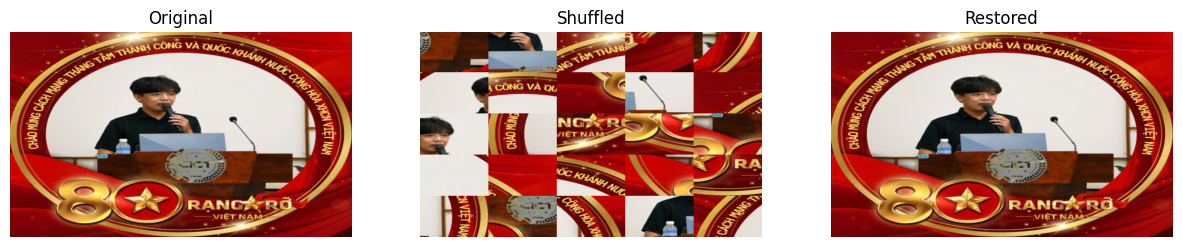

In [26]:
# 3) Khôi phục
restored, assignment = unscramble(shuffled, original, N)

# 4) Hiển thị bằng Matplotlib
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(original)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Shuffled")
plt.imshow(shuffled)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Restored")
plt.imshow(restored)
plt.axis("off")
plt.show()